<a href="https://colab.research.google.com/github/ceyxasm/ml/blob/main/Ensemble_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Ensemble Learning**

Suppose you build an ensemble containing 1,000 classifiers that are individ‐
ually correct only 51% of the time (barely better than random guessing). If you pre‐
dict the majority voted class, you can hope for up to 75% accuracy! However, this is
only true if all classifiers are perfectly independent, making uncorrelated errors



In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons( 500, noise=0.035, random_state=20)
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.33, random_state=42)

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier(max_depth=4)
svm_clf = SVC(C=0.05)
voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
voting='hard')
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier(max_depth=4)),
                             ('svc', SVC(C=0.05))])

In [2]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.896969696969697
RandomForestClassifier 0.9878787878787879
SVC 0.9636363636363636
VotingClassifier 0.9636363636363636


In [3]:
## implementing soft voting


log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier(max_depth=4)
svm_clf = SVC(C=0.05, probability=True) #<<<<<<<<<<<<<<<<<<<<<<<
voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
voting='soft')  #<<<<<<<<<<<<<<<<<<<<<<,  
voting_clf.fit(X_train, y_train)


for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.896969696969697
RandomForestClassifier 0.9878787878787879
SVC 0.9636363636363636
VotingClassifier 0.9454545454545454



Clearly are ensemble is not performing as it should.
reason being: we are training the models on same data. Errors will therefore be correlated.

 Using different classifier is one way of doing ensemble learning.
 
 .
 ----
**Bagging and Pasting**

use the same training algorithm for every
predictor, but to train them on different random subsets of the training set. When
sampling is performed with replacement, this method is called bagging . When sampling is performed without replacement, it is called
pasting. 

In [4]:
from sklearn.ensemble import BaggingClassifier  #BaggingRegressor for regression
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
  DecisionTreeClassifier(), n_estimators=500,
  max_samples=100, bootstrap=True, n_jobs=-1) #for pasting, bootstrap=False
'''here 500 Dtrees are trained on 100 randomly sampled instances'''

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print('Accuracy:  ', accuracy_score(y_pred, y_test))

Accuracy:   0.9878787878787879


Random Forest is an ensemble of Decision Trees, generally
trained via the bagging method (or sometimes pasting), typically with max_samples
set to the size of the training set.
But instead of passing a Decision Tree classifier in bagging Classifier, Random Forrest Classifier is more optimized.

In [5]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
print('Accuracy:  ', accuracy_score(y_pred, y_test))

Accuracy:   0.9878787878787879


In [6]:
##Extracting feature importances
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.08819387354215659
sepal width (cm) 0.02295555638064736
petal length (cm) 0.42864843450531487
petal width (cm) 0.4602021355718812


**BOOSTING**

The general idea of most
boosting methods is to train predictors sequentially, each trying to correct its predecessor.

In [7]:
'''
AdaBoost
One way for a new predictor to correct its predecessor is to pay a bit more attention
to the training instances that the predecessor underfitted. This results in new predic‐
tors focusing more and more on the hard cases. This is the technique used by Ada‐
Boost.

As this implementation cannot be paralleized; it doesn't scale.

Scikit implements SAAME: Stagewise Additive Modeling using a Multiclass Exponential loss function
when there are just 2 classes, SAAME= AdaBoost
'''
from sklearn.ensemble import AdaBoostClassifier #regressor also exists

ada_clf = AdaBoostClassifier(
  DecisionTreeClassifier(max_depth=1), n_estimators=200, #tree stump is a tree with max_depth=1
  algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)
y_pred= ada_clf.predict(X_test)

print('Accuracy:  ', accuracy_score(y_pred, y_test))

'''
If AdaBoost ensemble is overfitting the training set, 
try reducing the number of estimators or more strongly regulariz‐
ing the base estimator.'''

Accuracy:   0.9818181818181818


'\nIf AdaBoost ensemble is overfitting the training set, \ntry reducing the number of estimators or more strongly regulariz‐\ning the base estimator.'

In [8]:
'''
Gradient Bossting
this method tries to fit the new predictor to the residual
errors made by the previous predictor'''

#implemented Gradient Boosted Regression Tree

from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

y_pred = sum(tree.predict(X_test) for tree in (tree_reg1, tree_reg2, tree_reg3))


In [9]:
##Secondly, we can use inbuilt Scikit support
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

'''if learning rate is low, more trees needed in ensemble to fit the model but it will end up generalizing better'''

'if learning rate is low, more trees needed in ensemble to fit the model but it will end up generalizing better'

In [10]:
'''if too little trees, underfit
  if too many, over fit
  > solution: early stopping by using staged_predict() method'''

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors)
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=119)

In [14]:
## our best fit came at 119th tree

##Another highly scalable library is XGBoost; originally made for DMLC
import xgboost
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)

xgb_reg.fit(X_train, y_train,
eval_set=[(X_test, y_test)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_test)

'''to be explored more'''

[15:08:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:08:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.46069
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.426101
[2]	validation_0-rmse:0.39601
[3]	validation_0-rmse:0.369876
[4]	validation_0-rmse:0.348109
[5]	validation_0-rmse:0.328758
[6]	validation_0-rmse:0.312367
[7]	validation_0-rmse:0.291648
[8]	validation_0-rmse:0.27845
[9]	validation_0-rmse:0.261214
[10]	validation_0-rmse:0.250785
[11]	validation_0-rmse:0.236549
[12]	validation_0-rmse:0.22386
[13]	validation_0-rmse:0.215547
[14]	validation_0-rmse:0.204794
[15]	validation_0-rmse:0.197906
[16]	validation_0-rmse:0.185723
[17]	validation_0-rmse:0.177998
[18]	validation_0-rmse:0.171128
[19]	validation_0-rmse:0.161727
[20]	validation_0-rmse:0.15358
[21]	validation_0-rmse:0.

'to be explored more'

**STACKING**

instead of using trivial functions
(such as hard voting) to aggregate the predictions of all predictors in an ensemble,
why don’t we train a model to perform this aggregation?

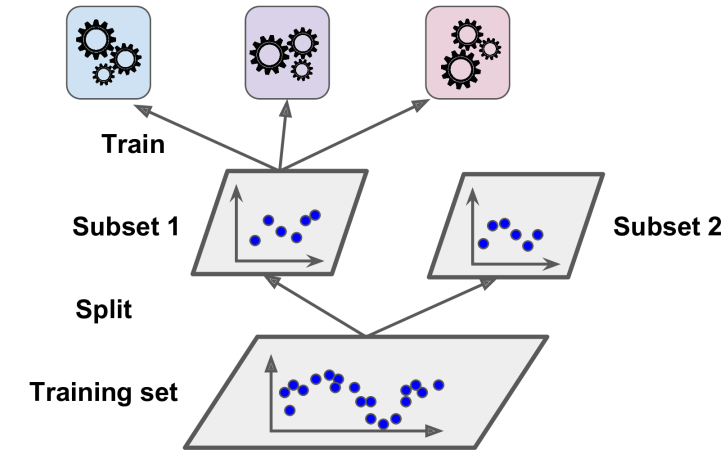

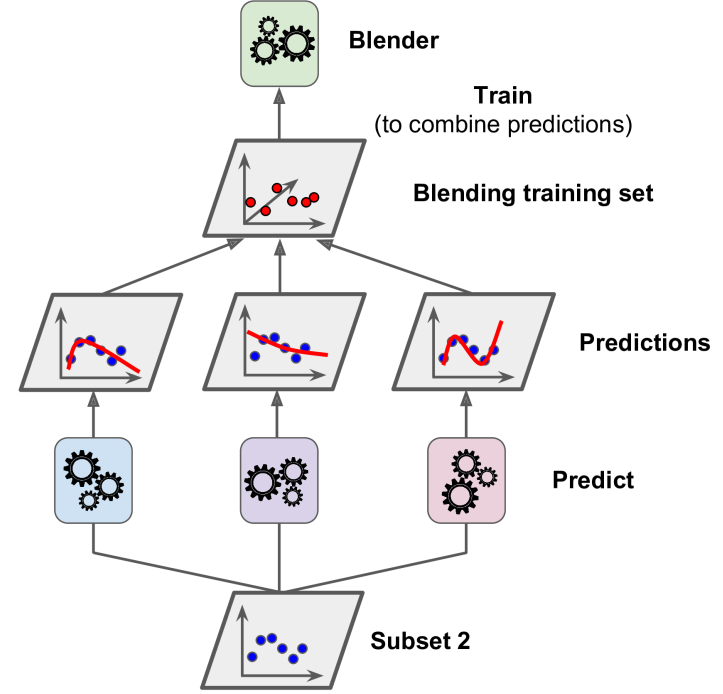

In [16]:
'''
Stacking is very similar to Neural net???

Various Ensemble Learning methods learned:
>Bagging and Pasting
>Random Forrest
>Boosting
>Stacking
'''

'\nStacking is very similar to Neural net???\n\nVarious Ensemble Learning methods learned:\n>Bagging and Pasting\n>Random Forrest\n>Boosting\n>Stacking\n'